In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile

# import sys
# sys.path.append('../')
# from alphastar import *



In [2]:
import numpy as np

NODE_STATE_INDEX = 0
NODE_G_INDEX = 1
NODE_H_INDEX = 2
NODE_PARENT_INDEX = 3
NODE_ACTION_INDEX = 4


class OpenSet:

    def __init__(self, threshold):
        self.diff_threshold = np.array(threshold)
        self.points = np.empty([0, threshold.shape[0]])
        self.nodes = []

    def append(self, node):
        self.nodes.append(node)
        self.points = np.append(self.points, np.atleast_2d(node[NODE_STATE_INDEX]), axis=0)

    def contains(self, node):
        diffs = np.abs(self.points - node[NODE_STATE_INDEX])
        comps = diffs < self.diff_threshold
        if np.any(np.logical_and.reduce(comps, axis=1)):
            return True
        return False

    def pop(self, i):
        node = self.nodes.pop(i)
        np.delete(self.points, i)
        return node

    def __len__(self):
        return len(self.nodes)


class CloseSet:

    def __init__(self, threshold):
        self.diff_threshold = np.array(threshold)

        self.points = np.empty([0, threshold.shape[0]])
        self.nodes = []

    def append(self, node):
        self.nodes.append(node)
        self.points = np.append(self.points, np.atleast_2d(node[NODE_STATE_INDEX]), axis=0)

    def contains(self, node):
        diffs = np.abs(self.points - node[NODE_STATE_INDEX])
        comps = diffs < self.diff_threshold
        if np.any(np.logical_and.reduce(comps, axis=1)):
            return True
        return False


def solve(start_state, goal_state, g_func, h_func, is_end_state_func, next_actions_func, next_states_func,
          state_similarity, max_iters=1000):
    def node(state, parent, action=None):  # !
        # node tuple: state, g, h, parent, action
        if parent is not None:
            p_state, p_g, p_h, p_parent, p_action = parent
        else:
            p_state, p_g, p_h, p_parent = state, 0., 0., None
        return state, g_func(state, p_state) + p_g, h_func(state, goal_state), parent, action

    state_len = len(start_state)

    assert state_len == len(goal_state)

    assert state_similarity is not None
    if isinstance(state_similarity, float) or isinstance(state_similarity, int):
        state_similarity = np.ones(state_len)*state_similarity

    start = node(start_state, None)
    goal = node(goal_state, None)

    open_set = OpenSet(state_similarity)
    close_set = CloseSet(state_similarity)

    open_set.append(start)

    iters = 0

    num_nodes_searched = 0

    while len(open_set) > 0 and iters < max_iters:
        fs = [node[NODE_G_INDEX] + node[NODE_H_INDEX] for node in open_set.nodes]  # !
        lowest_f_index = np.argmin(fs)

        current = open_set.pop(lowest_f_index)
        num_nodes_searched += 1

        close_set.append(current)
        if is_end_state_func(current[NODE_STATE_INDEX]):
            return current, num_nodes_searched, open_set.nodes, close_set.nodes

        next_actions = next_actions_func(current[NODE_STATE_INDEX])
        next_states = next_states_func(current[NODE_STATE_INDEX], next_actions)
        for state, action in zip(next_states, next_actions):

            successor = node(state, current, action)
            if close_set.contains(successor):
                continue

            if not open_set.contains(successor):  # !
                open_set.append(successor)

        iters += 1

    return start, num_nodes_searched, open_set.nodes, close_set.nodes


def path(result):
    states, actions = [], []
    current = result
    while current is not None:
        states.append(current[NODE_STATE_INDEX])
        actions.append(current[NODE_ACTION_INDEX])

        current = current[NODE_PARENT_INDEX]

    states.reverse()
    actions.reverse()
    return states, actions

In [3]:
maze_str1 = """+++++++++++++++++++++++++
+...........+...+.......+
+..+++..++.+++.++.+.++..+
+.......+...........+...+
+++.+.+++.+++.+.+...+++.+
+...+...........+.......+
+..++++.+..+++.++..+++..+
+.......+...+...+...+...+
+.++++.++.+.+.+.+++.+.+.+
+...+...+...+.......+...+
+.+.++..++..+++.+...+++++
+.......+.......+.......+
+++++.+.+.+++..++..++.+.+
+...+.+.....+...+...+...+
+.+.+.+++.+.+.+.++.++++.+
+...+...+...+...+.......+
+.+++++.++.+++..+.++++..+
+.......+...........+...+
+.+++++.+.+.+++.+++.+.+++
+...+...........+.......+
+.+++.++++.+++.++..+++..+
+.......+...+...........+
+E+++++++++++++++++++++++"""

maze_str2 = """+++++++++++++++++++++++++
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+E+++++++++++++++++++++++"""

maze_str3 = """+++++++++++++++++++++++++
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+.......................+
+++.....................+
+E+++++++++++++++++++++++"""





In [4]:
class MazeWrapper:
    
    def __init__(self, maze):
        self.table = [list(line) for line in maze.splitlines()]
        self.maze = ''.join([''.join(row) for row in self.table])
        self.width, self.height = len(self.table[0]), len(self.table)
        
    def get_maze_string(self):
        res = '\n'.join([''.join(row) for row in self.table])
        return res
    
    def clone(self):
        return MazeWrapper(self.get_maze_string())
    
    def get_pos_of(self, char):
        inds = np.where([c==char for c in self.maze])[0]
        return np.array([np.array([i%self.width, i//self.width]) for i in inds])

    def plot(self):
#         plt.figure(figsize=(3, 3))


        walls = self.get_pos_of('+')
        if len(walls):
            plt.scatter(walls[:, 0], walls[:, 1], c='m', marker='s')
        
        

        end = self.get_pos_of('E')
        if len(end):
            plt.scatter(end[:, 0], end[:, 1], c='r')

        nothings = self.get_pos_of('.')
        if len(nothings):
            plt.scatter(nothings[:, 0], nothings[:, 1], c='black', marker='s') 

        open_set = self.get_pos_of('o')
        if len(open_set):
            plt.scatter(open_set[:, 0], open_set[:, 1], c='y', marker='s') 

        close_set = self.get_pos_of('c')
        if len(close_set):
            plt.scatter(close_set[:, 0], close_set[:, 1], c='gray', marker='s') 

        path = self.get_pos_of('p')
        if len(path):
            plt.scatter(path[:, 0], path[:, 1], c='b', marker='s') 
            
        start = self.get_pos_of('S')
        if len(start):
            plt.scatter(start[:, 0], start[:, 1], c='g', marker='s')

        plt.gca().invert_yaxis()
#         plt.show()
        
    def valid_directions(self, at_point):
        at_point = np.array(at_point)
        dir_vectors = np.array([[-1, 0], [0, -1], [1, 0], [0, 1], [-1, -1], [1, 1], [1, -1], [-1, 1]])
        next_states = dir_vectors+at_point
        res = [self.table[y][x] for x, y in next_states]
        return np.array([dir_vectors[i] for i, v in enumerate(res) if v=='.' or v=='E'])
    
    def replace_points_with(self, points, char):
        for x, y in points:
            self.table[y][x] = char
        self.maze = ''.join([''.join(row) for row in self.table])


In [5]:
# maze = MazeWrapper(maze_str1)
# goal = maze.get_pos_of('E')[0]
# h_func = lambda state, g_state:  np.sum(np.abs(state-g_state))
# accesible_states = maze.get_pos_of('.')
# hs = np.array([h_func(state, goal) for state in accesible_states])
# walls = maze.get_pos_of('+')
# plt.scatter(walls[:, 0], walls[:, 1], c='gray')
# plt.scatter(accesible_states[:, 0], accesible_states[:, 1], c=hs)
# plt.colorbar()
# plt.gca().invert_yaxis()
# plt.show()

In [6]:
def solve_maze(maze, start, max_iters=1000):
    start = np.array(start)
    goal = maze.get_pos_of('E')[0]
    g_func = lambda state, p_state: np.linalg.norm(state-p_state)
#     g_func = lambda state, p_state: 1
    h_func = lambda state, g_state: np.linalg.norm(state-g_state)
#     h_func = lambda state, g_state: np.sum(np.abs(state-g_state))
    is_end_state_func = lambda state: np.all(state == goal)
    next_actions_func = lambda state: maze.valid_directions(state)
    next_states_func = lambda state, actions: state+actions
    states_close_limit = np.array([0.5, 0.5])
    return solve(start, goal, g_func, h_func, is_end_state_func, next_actions_func, next_states_func, states_close_limit, max_iters)
    


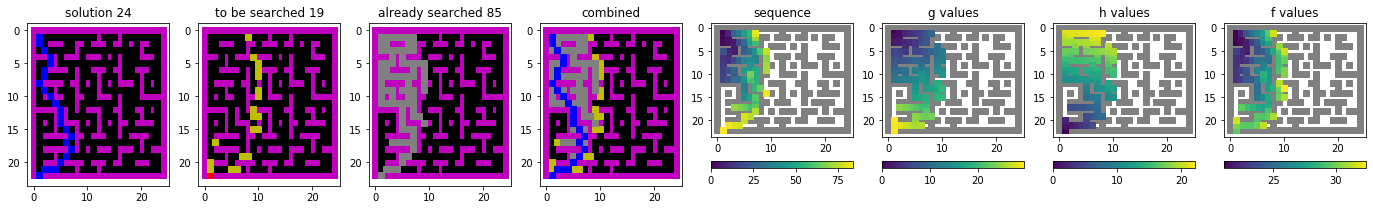

map dims: w 25, h 23
numbers ofnodes to be searched 19
numbers ofnodes searched 85
total numbers of accesible nodes 311
path length 24
path over searched 0.2823529411764706 search over all 0.2733118971061093 path over all 0.07717041800643087


(0.2823529411764706, 0.2733118971061093, 0.07717041800643087)

In [7]:
def test_optimality(maze_str, start):
    subplots = 8
    maze = MazeWrapper(maze_str)
    result, n, open_set, close_set = solve_maze(maze, start)
    states, actions = path(result)
    
    n_path = len(states)
    n_unsearched = len(open_set)
    n_searched = len(close_set)
    
    plt.figure(figsize=(3*subplots, 3))
    plt.tight_layout()
    plt.subplot(1, subplots, 1)
    plt.title(f"solution {n_path}")
    solution_maze = maze.clone()
    solution_maze.replace_points_with(states, 'p')
    solution_maze.plot()
    
    plt.subplot(1, subplots, 2)
    plt.title(f"to be searched {n_unsearched}")
    states = np.array([node[0] for node in open_set])
    open_set_maze = maze.clone()
    open_set_maze.replace_points_with(states, 'o')
    open_set_maze.plot()
    
    plt.subplot(1, subplots, 3)
    plt.title(f"already searched {n_searched}")
    states = np.array([node[0] for node in close_set])
    close_set_maze = maze.clone()
    close_set_maze.replace_points_with(states, 'c')
    close_set_maze.plot()
    
    plt.subplot(1, subplots, 4)
    plt.title("combined")
    combined = close_set_maze.clone()
    combined.replace_points_with(np.array([node[0] for node in open_set]), 'o')
    states, actions = path(result)
    combined.replace_points_with(states, 'p')
    combined.plot()
    
    plt.subplot(1, subplots, 5)
    plt.title("sequence")
    states = np.array([node[0] for node in close_set])
    seq = np.array([i for i, state in enumerate(states)])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=seq, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(1, subplots, 6)
    plt.title("g values")
    states = np.array([node[0] for node in close_set+open_set])
    gs = np.array([node[1] for node in close_set+open_set])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=gs, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(1, subplots, 7)
    plt.title("h values")
    states = np.array([node[0] for node in close_set+open_set])
    hs = np.array([node[2] for node in close_set+open_set])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=hs, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(1, subplots, 8)
    plt.title("f values")
    states = np.array([node[0] for node in close_set+open_set])
    fs = np.array([node[1]+node[2] for node in close_set+open_set])
    walls = maze.get_pos_of('+')
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(states[:, 0], states[:, 1], c=fs, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar(orientation='horizontal')
    
    plt.show()
    
    
    n_all = len(maze.get_pos_of('.'))
    print(f"map dims: w {maze.width}, h {maze.height}")
    print('numbers ofnodes to be searched', n_unsearched)
    print('numbers ofnodes searched', n_searched)
    print('total numbers of accesible nodes', n_all)
    print('path length', n_path)
    searched_over_all = n_searched/n_all
    path_over_all = n_path/n_all
    path_over_searched = n_path/n_searched
    print('path over searched', path_over_searched, 'search over all', searched_over_all, 'path over all', path_over_all)
    return path_over_searched, searched_over_all, path_over_all
test_optimality(maze_str1, [1, 1])

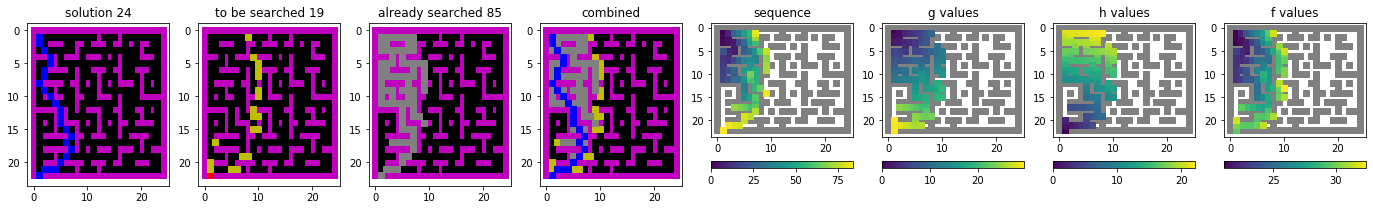

map dims: w 25, h 23
numbers ofnodes to be searched 19
numbers ofnodes searched 85
total numbers of accesible nodes 311
path length 24
path over searched 0.2823529411764706 search over all 0.2733118971061093 path over all 0.07717041800643087


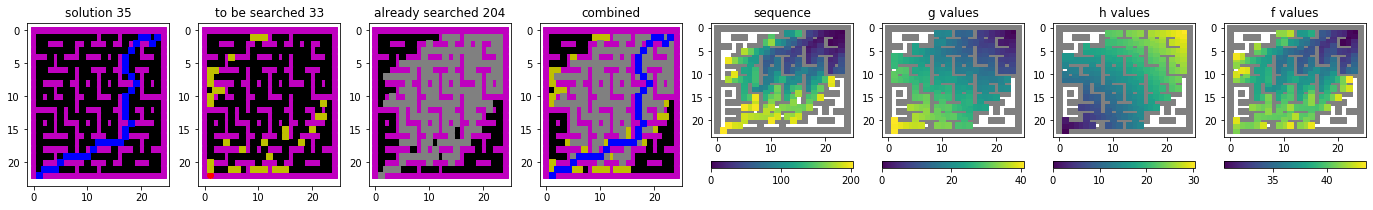

map dims: w 25, h 23
numbers ofnodes to be searched 33
numbers ofnodes searched 204
total numbers of accesible nodes 311
path length 35
path over searched 0.1715686274509804 search over all 0.6559485530546624 path over all 0.11254019292604502


(0.1715686274509804, 0.6559485530546624, 0.11254019292604502)

In [8]:
test_optimality(maze_str1, [1, 1])
test_optimality(maze_str1, [23, 1])

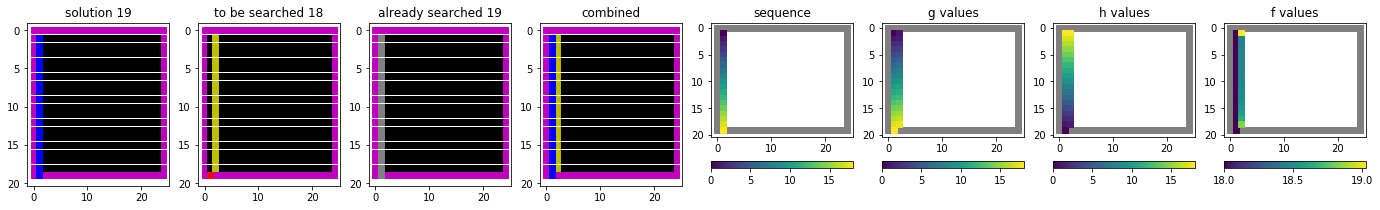

map dims: w 25, h 20
numbers ofnodes to be searched 18
numbers ofnodes searched 19
total numbers of accesible nodes 414
path length 19
path over searched 1.0 search over all 0.04589371980676329 path over all 0.04589371980676329


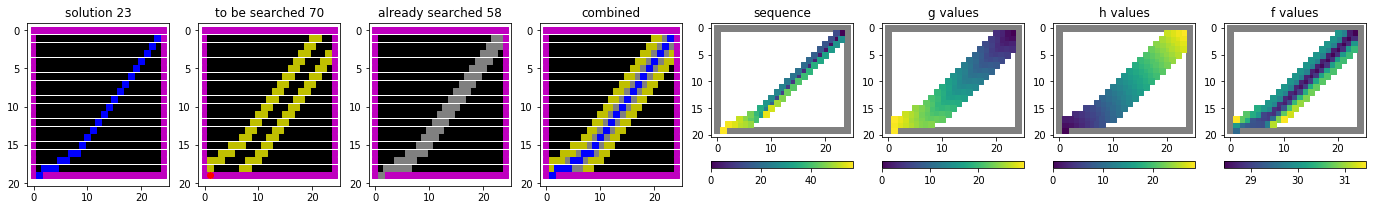

map dims: w 25, h 20
numbers ofnodes to be searched 70
numbers ofnodes searched 58
total numbers of accesible nodes 414
path length 23
path over searched 0.39655172413793105 search over all 0.14009661835748793 path over all 0.05555555555555555


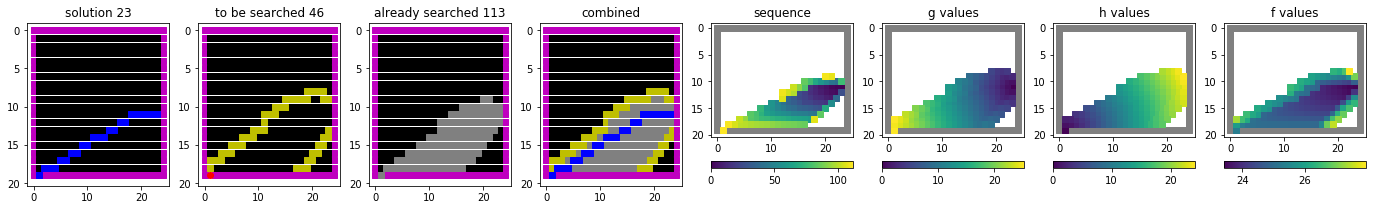

map dims: w 25, h 20
numbers ofnodes to be searched 46
numbers ofnodes searched 113
total numbers of accesible nodes 414
path length 23
path over searched 0.20353982300884957 search over all 0.27294685990338163 path over all 0.05555555555555555


(0.20353982300884957, 0.27294685990338163, 0.05555555555555555)

In [9]:
test_optimality(maze_str2, [1, 1])
test_optimality(maze_str2, [23, 1])
test_optimality(maze_str2, [23, 11])

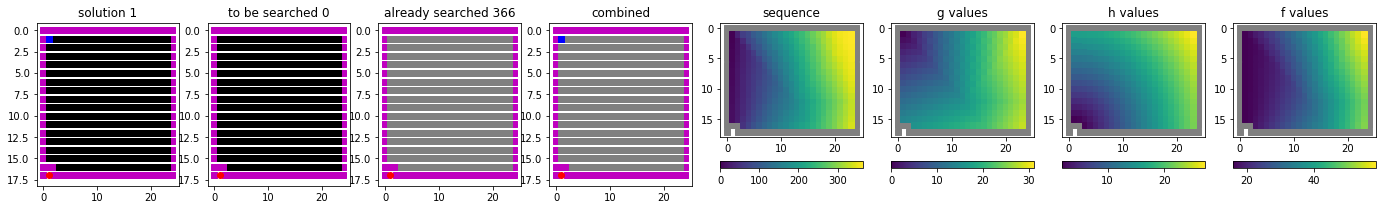

map dims: w 25, h 18
numbers ofnodes to be searched 0
numbers ofnodes searched 366
total numbers of accesible nodes 366
path length 1
path over searched 0.00273224043715847 search over all 1.0 path over all 0.00273224043715847


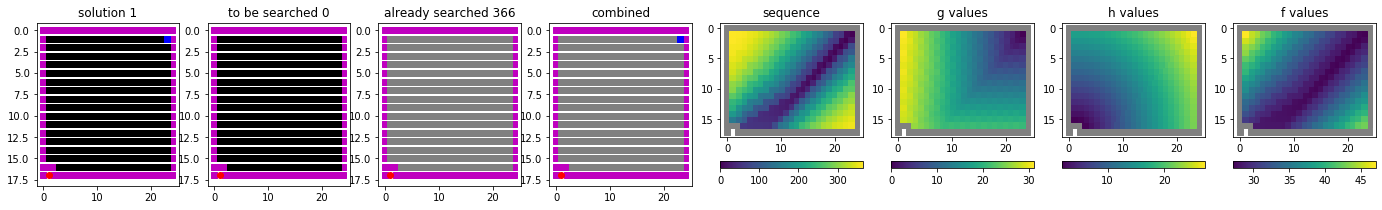

map dims: w 25, h 18
numbers ofnodes to be searched 0
numbers ofnodes searched 366
total numbers of accesible nodes 366
path length 1
path over searched 0.00273224043715847 search over all 1.0 path over all 0.00273224043715847


(0.00273224043715847, 1.0, 0.00273224043715847)

In [10]:
test_optimality(maze_str3, [1, 1])
test_optimality(maze_str3, [23, 1])

In [11]:
import time
def test_performance(maze_str):
    maze = MazeWrapper(maze_str)
    starts = maze.get_pos_of('.')
    times = []
    for i, start in enumerate(starts):
        now = time.perf_counter()
        result, n, open_set, close_set = solve_maze(maze, start)
        elapsed = time.perf_counter()-now
        print(f'{i}: solve for {start} took {elapsed} seconds')
        times.append(elapsed)
    times = np.array(times)
    total = times.sum()
    print(f'total time:{total} seconds for {len(times)} searches')
    walls = maze.get_pos_of('+')
    plt.figure(figsize=(4, 3))
    plt.scatter(walls[:, 0], walls[:, 1], c='gray', marker='s')
    plt.scatter(starts[:, 0], starts[:, 1], c=times, marker='s')
    plt.gca().invert_yaxis()
    plt.colorbar()
    
    return total, starts, times

0: solve for [1 1] took 0.022963400000000002 seconds
1: solve for [2 1] took 0.017440900000000002 seconds
2: solve for [3 1] took 0.021861900000000004 seconds
3: solve for [4 1] took 0.024009500000000003 seconds
4: solve for [5 1] took 0.024275099999999994 seconds
5: solve for [6 1] took 0.023857099999999992 seconds
6: solve for [7 1] took 0.02756439999999999 seconds
7: solve for [8 1] took 0.032251100000000005 seconds
8: solve for [9 1] took 0.03233349999999999 seconds
9: solve for [10  1] took 0.03174650000000001 seconds
10: solve for [11  1] took 0.030104799999999987 seconds
11: solve for [13  1] took 0.039010199999999995 seconds
12: solve for [14  1] took 0.03932899999999995 seconds
13: solve for [15  1] took 0.033655199999999996 seconds
14: solve for [17  1] took 0.0511278 seconds
15: solve for [18  1] took 0.04951370000000005 seconds
16: solve for [19  1] took 0.05678810000000001 seconds
17: solve for [20  1] took 0.05744130000000003 seconds
18: solve for [21  1] took 0.058916200

155: solve for [ 7 11] took 0.011632600000000437 seconds
156: solve for [ 9 11] took 0.010267100000000084 seconds
157: solve for [10 11] took 0.009499899999999784 seconds
158: solve for [11 11] took 0.012055199999999822 seconds
159: solve for [12 11] took 0.01510440000000024 seconds
160: solve for [13 11] took 0.01589509999999983 seconds
161: solve for [14 11] took 0.01375499999999974 seconds
162: solve for [15 11] took 0.013815600000000039 seconds
163: solve for [17 11] took 0.01952969999999965 seconds
164: solve for [18 11] took 0.02041499999999985 seconds
165: solve for [19 11] took 0.01900119999999994 seconds
166: solve for [20 11] took 0.019454000000000526 seconds
167: solve for [21 11] took 0.01949690000000004 seconds
168: solve for [22 11] took 0.022373700000000163 seconds
169: solve for [23 11] took 0.01873690000000039 seconds
170: solve for [ 5 12] took 0.006827600000000267 seconds
171: solve for [ 7 12] took 0.010964000000000418 seconds
172: solve for [ 9 12] took 0.009196799

302: solve for [15 21] took 0.005648099999999268 seconds
303: solve for [16 21] took 0.00586899999999968 seconds
304: solve for [17 21] took 0.006443399999999322 seconds
305: solve for [18 21] took 0.007472500000000437 seconds
306: solve for [19 21] took 0.0075416999999999845 seconds
307: solve for [20 21] took 0.007668699999999973 seconds
308: solve for [21 21] took 0.008288499999999921 seconds
309: solve for [22 21] took 0.009289399999999226 seconds
310: solve for [23 21] took 0.01018130000000017 seconds
total time:5.534649799999997 seconds for 311 searches


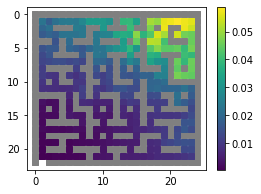

In [12]:
total, starts, times = test_performance(maze_str1)

0: solve for [1 1] took 0.0062493999999997385 seconds
1: solve for [2 1] took 0.013310500000000225 seconds
2: solve for [3 1] took 0.02185590000000026 seconds
3: solve for [4 1] took 0.027777699999999683 seconds
4: solve for [5 1] took 0.0314255999999995 seconds
5: solve for [6 1] took 0.03397830000000024 seconds
6: solve for [7 1] took 0.035326099999999805 seconds
7: solve for [8 1] took 0.035714599999999486 seconds
8: solve for [9 1] took 0.036033699999999946 seconds
9: solve for [10  1] took 0.03441630000000018 seconds
10: solve for [11  1] took 0.031041899999999956 seconds
11: solve for [12  1] took 0.02957199999999993 seconds
12: solve for [13  1] took 0.02616390000000024 seconds
13: solve for [14  1] took 0.021592800000000523 seconds
14: solve for [15  1] took 0.021294499999999772 seconds
15: solve for [16  1] took 0.021012400000000042 seconds
16: solve for [17  1] took 0.02113030000000027 seconds
17: solve for [18  1] took 0.0164755999999997 seconds
18: solve for [19  1] took 0.

160: solve for [23  7] took 0.034119000000000455 seconds
161: solve for [1 8] took 0.004446500000000242 seconds
162: solve for [2 8] took 0.00787910000000025 seconds
163: solve for [3 8] took 0.010887900000000172 seconds
164: solve for [4 8] took 0.013806299999998828 seconds
165: solve for [5 8] took 0.014485600000000431 seconds
166: solve for [6 8] took 0.01369850000000028 seconds
167: solve for [7 8] took 0.012164200000000847 seconds
168: solve for [8 8] took 0.01188630000000046 seconds
169: solve for [9 8] took 0.011616399999999416 seconds
170: solve for [10  8] took 0.011326200000000952 seconds
171: solve for [11  8] took 0.00961110000000076 seconds
172: solve for [12  8] took 0.005480099999999766 seconds
173: solve for [13  8] took 0.00991989999999987 seconds
174: solve for [14  8] took 0.01330710000000046 seconds
175: solve for [15  8] took 0.014614099999999297 seconds
176: solve for [16  8] took 0.01566679999999998 seconds
177: solve for [17  8] took 0.017446800000000096 seconds

314: solve for [16 14] took 0.021400699999999162 seconds
315: solve for [17 14] took 0.023707399999999268 seconds
316: solve for [18 14] took 0.026707999999999288 seconds
317: solve for [19 14] took 0.02892579999999967 seconds
318: solve for [20 14] took 0.03141579999999955 seconds
319: solve for [21 14] took 0.0337013000000006 seconds
320: solve for [22 14] took 0.03638809999999992 seconds
321: solve for [23 14] took 0.0330010000000005 seconds
322: solve for [ 1 15] took 0.0016063000000006156 seconds
323: solve for [ 2 15] took 0.0027908000000014255 seconds
324: solve for [ 3 15] took 0.0028794999999988136 seconds
325: solve for [ 4 15] took 0.0031262999999999153 seconds
326: solve for [ 5 15] took 0.002017199999999164 seconds
327: solve for [ 6 15] took 0.0035311000000000092 seconds
328: solve for [ 7 15] took 0.0038687000000017235 seconds
329: solve for [ 8 15] took 0.005028799999999833 seconds
330: solve for [ 9 15] took 0.005569500000000005 seconds
331: solve for [10 15] took 0.00

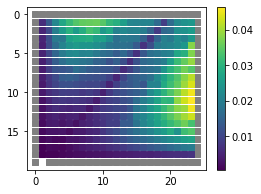

In [13]:
total, starts, times = test_performance(maze_str2)

0: solve for [1 1] took 0.15590280000000156 seconds
1: solve for [2 1] took 0.15514250000000018 seconds
2: solve for [3 1] took 0.13844270000000058 seconds
3: solve for [4 1] took 0.15440539999999991 seconds
4: solve for [5 1] took 0.1570569000000006 seconds
5: solve for [6 1] took 0.15578119999999984 seconds
6: solve for [7 1] took 0.15773569999999992 seconds
7: solve for [8 1] took 0.15667549999999864 seconds
8: solve for [9 1] took 0.16069569999999977 seconds
9: solve for [10  1] took 0.1568245000000008 seconds
10: solve for [11  1] took 0.15753020000000006 seconds
11: solve for [12  1] took 0.1570292999999996 seconds
12: solve for [13  1] took 0.15842029999999951 seconds
13: solve for [14  1] took 0.15772850000000105 seconds
14: solve for [15  1] took 0.1584827999999998 seconds
15: solve for [16  1] took 0.16718980000000094 seconds
16: solve for [17  1] took 0.15352429999999906 seconds
17: solve for [18  1] took 0.1303465999999993 seconds
18: solve for [19  1] took 0.14791829999999

152: solve for [15  7] took 0.15748399999999663 seconds
153: solve for [16  7] took 0.12457589999999641 seconds
154: solve for [17  7] took 0.13824130000000423 seconds
155: solve for [18  7] took 0.15559660000000264 seconds
156: solve for [19  7] took 0.14792260000000113 seconds
157: solve for [20  7] took 0.15670270000000386 seconds
158: solve for [21  7] took 0.15572039999999987 seconds
159: solve for [22  7] took 0.15589370000000002 seconds
160: solve for [23  7] took 0.15620960000000395 seconds
161: solve for [1 8] took 0.15278659999999888 seconds
162: solve for [2 8] took 0.15343749999999545 seconds
163: solve for [3 8] took 0.1534556000000009 seconds
164: solve for [4 8] took 0.13187959999999777 seconds
165: solve for [5 8] took 0.15337989999999735 seconds
166: solve for [6 8] took 0.1531529999999961 seconds
167: solve for [7 8] took 0.15283249999999526 seconds
168: solve for [8 8] took 0.13470279999999946 seconds
169: solve for [9 8] took 0.15444289999999938 seconds
170: solve f

300: solve for [ 2 14] took 0.15440130000000352 seconds
301: solve for [ 3 14] took 0.1529111000000043 seconds
302: solve for [ 4 14] took 0.15344720000000223 seconds
303: solve for [ 5 14] took 0.1537046999999987 seconds
304: solve for [ 6 14] took 0.15492199999999912 seconds
305: solve for [ 7 14] took 0.15415070000000242 seconds
306: solve for [ 8 14] took 0.14261390000000063 seconds
307: solve for [ 9 14] took 0.1539135000000016 seconds
308: solve for [10 14] took 0.15389050000000282 seconds
309: solve for [11 14] took 0.15459629999999436 seconds
310: solve for [12 14] took 0.13393860000000046 seconds
311: solve for [13 14] took 0.15436890000000147 seconds
312: solve for [14 14] took 0.156811900000001 seconds
313: solve for [15 14] took 0.12622470000000163 seconds
314: solve for [16 14] took 0.15382039999999364 seconds
315: solve for [17 14] took 0.15328829999999982 seconds
316: solve for [18 14] took 0.15533940000000257 seconds
317: solve for [19 14] took 0.15474000000000387 secon

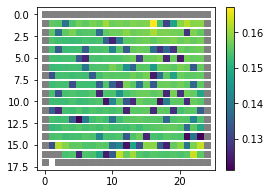

In [14]:
total, starts, times = test_performance(maze_str3)

In [15]:
maze = MazeWrapper(maze_str1)
starts = maze.get_pos_of('.')
print(cProfile.run('[solve_maze(maze, start) for start in starts]'))

         5983205 function calls (5739589 primitive calls) in 6.521 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20939    0.014    0.000    0.131    0.000 <__array_function__ internals>:2(all)
   135237    0.084    0.000    0.743    0.000 <__array_function__ internals>:2(any)
    48529    0.031    0.000    0.301    0.000 <__array_function__ internals>:2(append)
    20939    0.013    0.000    0.248    0.000 <__array_function__ internals>:2(argmin)
    48529    0.031    0.000    0.195    0.000 <__array_function__ internals>:2(atleast_2d)
    48529    0.031    0.000    0.175    0.000 <__array_function__ internals>:2(concatenate)
    20939    0.014    0.000    0.350    0.000 <__array_function__ internals>:2(delete)
   174148    0.092    0.000    0.324    0.000 <__array_function__ internals>:2(dot)
   174148    0.096    0.000    1.624    0.000 <__array_function__ internals>:2(norm)
      311    0.000    0.000    0.007    0

In [16]:
maze = MazeWrapper(maze_str2)
starts = maze.get_pos_of('.')
print(cProfile.run('[solve_maze(maze, start) for start in starts]'))

         7442929 function calls (7135648 primitive calls) in 7.634 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    16698    0.011    0.000    0.104    0.000 <__array_function__ internals>:2(all)
   196320    0.117    0.000    0.971    0.000 <__array_function__ internals>:2(any)
    48111    0.031    0.000    0.294    0.000 <__array_function__ internals>:2(append)
    16698    0.011    0.000    0.221    0.000 <__array_function__ internals>:2(argmin)
    48111    0.030    0.000    0.192    0.000 <__array_function__ internals>:2(atleast_2d)
    48111    0.030    0.000    0.170    0.000 <__array_function__ internals>:2(concatenate)
    16698    0.011    0.000    0.286    0.000 <__array_function__ internals>:2(delete)
   242472    0.126    0.000    0.435    0.000 <__array_function__ internals>:2(dot)
   242472    0.130    0.000    2.182    0.000 <__array_function__ internals>:2(norm)
      414    0.000    0.000    0.009    0

In [17]:
maze = MazeWrapper(maze_str3)
starts = maze.get_pos_of('.')
print(cProfile.run('[solve_maze(maze, start) for start in starts]'))

         57009262 function calls (54629164 primitive calls) in 60.191 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   133956    0.082    0.000    0.805    0.000 <__array_function__ internals>:2(all)
  1482300    0.842    0.000    7.039    0.000 <__array_function__ internals>:2(any)
   267912    0.171    0.000    1.677    0.000 <__array_function__ internals>:2(append)
   133956    0.080    0.000    1.657    0.000 <__array_function__ internals>:2(argmin)
   267912    0.167    0.000    1.084    0.000 <__array_function__ internals>:2(atleast_2d)
   267912    0.166    0.000    0.988    0.000 <__array_function__ internals>:2(concatenate)
   133956    0.084    0.000    2.242    0.000 <__array_function__ internals>:2(delete)
  1977864    0.976    0.000    3.332    0.000 <__array_function__ internals>:2(dot)
  1977864    1.003    0.000   16.804    0.000 <__array_function__ internals>:2(norm)
      366    0.000    0.000    0.006  